HHU Deep Learning, WS2023/24, 17.11.2023

Lecture: Prof. Dr. Markus Kollmann

Exercises: Nikolas Adaloglou, Felix Michels

# Assignment 6 - Neural Networks with PyTorch

---

Submit the solved notebook (not a zip) with your full name plus assingment number for the filename as an indicator, e.g `max_mustermann_a1.ipynb` for assignment 1. If we feel like you have genuinely tried to solve the exercise, you will receive 1 point for this assignment, regardless of the quality of your solution.

## <center> DUE FRIDAY 24.11.2023 2:30 pm </center>

Drop-off link: [https://uni-duesseldorf.sciebo.de/s/1OQhEkR4QtlzkfF](https://uni-duesseldorf.sciebo.de/s/1OQhEkR4QtlzkfF)

---

Until now, we have used the numpy package to write our own helper functions for forward-, backward-passes of layers, activation functions, wrote our own cost functions and optimizers, etc. Now, we want to automate all of this with the use of a Deep Learning Framework.

There are various big packages (frameworks) that offer functionality specialized in Machine/Deep Learning.

The two most well known ones are **PyTorch** from Meta and **TensorFlow** from Google. In this course, we will work with PyTorch as it provides a good tradeoff between ease of use for academic purposes and scalability to large projects in future reasearch.

Next to implementations of functions like Neural Network layers, optimizers, etc., PyTorch has three main features:
- The tensor datastructure, which is similar to the Numpy ndarray
- Automatic differentiation for training neural networks
- It allows us to run code on a GPU, which offers significantly  faster computations.

![Pytorch_logo.png](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a06_pytorch_mlp/images/Pytorch_logo.png)

Feel free to use the PyTorch Introduction from week 1 as a look-up for basic PyTorch functionality.

---

For this assignment, you will use PyTorch to implement a fully connected Neural Network, perform a set of experiments on the famous CIFAR10 dataset and report your results and findings.

For your experiments, you will create a multilayer perceptron (MLP) Neural Network and train it on the CIFAR10 dataset to predict object class based on the input image. CIFAR10 image dimensions are 32 by 32, with 3 values for each pixel (R, G, B).

**Goal: Your goal is to develop an image classifier that scores more than 50% accuracy on the validation data.**

# 1. Imports and preparing the dataset and dataloaders


If you are using google colab remember to change the runtime type to GPU.

To get started, run the following code to import the libraries you will need.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We will be using a GPU to accelerate training and testing. PyTorch lets you use the GPU with very little additional code. The `torch.cuda` package contains all available functions for GPU usage. Check out the docs on the [package](https://pytorch.org/docs/stable/cuda.html) and on [cuda semantics](https://pytorch.org/docs/stable/notes/cuda.html#cuda-semantics) if you want to learn more, this is not required for this assignment though.

If you don't have a dedicated GPU in your own machine, the easiest way to get one is Google Colab! It's free, all you need is a Google account and you get ~8 hrs of GPU time per day.

Below is a small, good-practice, GPU setup to check the availability of a GPU in your system.

In [3]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device:', device)

device: cpu


# 2. CIFAR-10 Dataset

Today, we'll use the famous CIFAR-10 dataset for an image classification task. PyTorch provides many built-in datasets in the [torchvision.datasets](https://pytorch.org/vision/stable/datasets.html) module, as well as utility classes for building your own datasets.

The code below:
- Defines some basic transforms for preprocessing the data
- Loads the CIFAR-10 dataset as a PyTorch dataset class. The raw data is stored locally on your machine.

In [4]:
# Data transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 58363229.54it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


PyTorch provides a convenient solution for batch training. After loading the dataset and setting parameters like batch_size, train and an optional transformation (normalization in this case), we can use the DataLoader object as an iterator for the training loop. It will return the outputs of the `__getitem__(...)` function of the dataset class in a batched form, ready to be used for batch-gradient descent.

**Exercise:** Instantiate two DataLoaders, one for the training set and one for the validation set. Adjust the batch size to your available GPU memory, usual choices are powers of 2, like 16, 32, 64, ..., for reasons that have to do with the hardware layout on GPUs.

In [5]:
### START CODE HERE ### (approx. 2 lines)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)

### END CODE HERE ###

Below you can see how to access information regarding the dataset and the dataloaders.

In [6]:
# dataset instance
print("List of label names are:", trainset.classes)
print("Total training images:", len(trainset))
img, label = trainset[0]
print(f"Example image with shape {img.shape}, label {label}, which is a {trainset.classes[label]} ")

# DataLoader instance
print(f'The dataloader contains {len(train_loader)} batches.')
imgs_batch , labels_batch = next(iter(train_loader))
print(f"A batch of images has shape {imgs_batch.shape}, labels {labels_batch.shape}")

List of label names are: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Total training images: 50000
Example image with shape torch.Size([3, 32, 32]), label 6, which is a frog 
The dataloader contains 1563 batches.
A batch of images has shape torch.Size([32, 3, 32, 32]), labels torch.Size([32])


# 3. Define the MLP model

Now it's your turn to implement a Multi-Layer Perceptron (MLP / fully connected net) with variable depth, similar to the last exercise. Your Network needs to:

- Have L-1 blocks of linear layers, followed by ReLU activations, check out nn.Linear and nn.ReLU
- Have a final 'out_layer' with just a linear layer
- Have choosable dimensions for all hidden layers, via the 'hidden_sizes' parameter, e.g. [32, 16] is a three-layer model.

The `torch.nn` functions, like `nn.Linear`, have all the functionality you need for training the network already built into them. No more manual backward-computation or remembering intermediate results in a cache, PyTorch takes care of that.

You need to define your network architecture in the `__init__`, by initialising things like layers and activation functions and then call them in the forward pass to process the input `x`.

Tip: In the `__init__`, you can save 'nn.' objects in a list and then pass them to `nn.Sequential` as an unpacked list:

```
layers = nn.ModuleList()
... fill the list ...
self.layers = nn.Sequential(*layers)
```

See the `PyTorch Module API` and `PyTorch Sequential API` sections from the PyTorch Introduction from week 1 for help on the implementation here.

In [7]:
# Model structure
class MLP(nn.Module):
    def __init__(self, in_channels, num_classes, hidden_sizes=[64]):
        super(MLP, self).__init__()
        assert len(hidden_sizes) >= 1 , "specify at least one hidden layer"
        ### START CODE HERE ### (approx. 7 lines)
        layers = nn.ModuleList()
        layers.append(nn.Linear(in_channels, hidden_sizes[0]))
        layers.append(nn.ReLU(True))
        l_h = len(hidden_sizes)
        for i in range(0, l_h-1):
          layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
          layers.append(nn.ReLU(True))
        self.layers = nn.Sequential(*layers)
        self.out_layers = nn.Linear(hidden_sizes[l_h-1],num_classes)
        self.layers = nn.Sequential(*layers)

        ### END CODE HERE ###

    def forward(self, x):
        ### START CODE HERE ### (approx. 3 lines)
        n = x.shape[0]
        x = x.view(n, -1)
        out = self.layers(x)
        out = self.out_layers(out)

        ### END CODE HERE ###
        return out

Use the function below to test your implementation. The parameter settings are not fitted to CIFAR-10, you will need different values later on!

Below you also find an expected output of what the network structure should look like. Note that this print varies based on your syntax, even if the logic is correct. Use it as a guide, you don't need to exactly replicate it.

In [8]:
# Test your implementation with random data
test_model = MLP(in_channels=3*10*10, num_classes=4, hidden_sizes=[64, 32, 16]).to(device)

a = torch.rand(16, 3, 10, 10).to(device)
b = test_model(a)
assert b.shape == (16,4)
print('Shape test passed')
print(test_model)

Shape test passed
MLP(
  (layers): Sequential(
    (0): Linear(in_features=300, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU(inplace=True)
  )
  (out_layers): Linear(in_features=16, out_features=4, bias=True)
)


**Expected Output:**

```
Shape test passed
Net(
  (layers): Sequential(
    (0): Linear(in_features=300, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
  )
  (out_layer): Linear(in_features=16, out_features=4, bias=True)
)
```

# 4. Training and Validation

Equipped with our MLP model, we now want to train it.

First, we implement the validation function, so we can use it in the train function. The idea is to test our model on the (unseen) validation data in regular intervals during training, e.g. after every epoch (traversal of the whole dataset).

**Exercise:** Implement the validation function, which reads in data from the `val_loader`, runs a forward pass and records the classification accuracy, as well as the loss. Both are returned for plotting purposes.

We will be using the `nn.CrossEntropyLoss` as our loss function. Please have a look at the [docs](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) for this loss function, you will use it more often in the future.

Loss functions in PyTorch are instantiated as class objects (nn.CrossEntropyLoss is the class here) and can then be used like a function:

```
criterion = nn.CrossEntropyLoss()
loss = criterion(input,target)
```

Note, that `nn.CrossEntropyLoss` combines a Softmax activation with the actual loss function, a negative log-likelihood loss. So, it expects **unnormalized!** scores from our network, i.e. no activation funciton after the last layer.

In [19]:
def validation(model, val_loader):
    criterion = nn.CrossEntropyLoss()
    correct = 0
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            ### START CODE HERE ### (approx. 8 lines)
            model.eval()
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predicted_class = outputs.max(dim=1)[1]
            val_loss += criterion(outputs, labels)
            correct +=(predicted_class == labels).float().sum().item()
    val_acc = correct/ len(valset)
    val_loss = val_loss/len(valset)

    ### END CODE HERE ###
    return val_acc, val_loss

In [20]:
# Don't mind this, is just for testing
class dummy_dataset(torch.utils.data.Dataset):
    def __init__(self):
        self.data = torch.rand(16, 3, 10, 10)
        self.labels = torch.randint(0, 4, (16,))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

Use the code below to test your implementation with the above initialized `test_model`.

In [21]:
# Test validation with an untrained model
test_set = dummy_dataset()
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4)

# Needs to run without errors
validation(test_model, test_loader)

(0.0003, tensor(0.0006))

Now, we can implement the train loop itself.  You are already familiar with the basic training procedure:

Loop for num_iterations:
1. Forward propagation
2. Compute loss function
3. Backward propagation
4. Update parameters

In [22]:
def train(model, train_loader, val_loader, epochs, lr, momentum, wd):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=wd)
    train_loss_hist = []
    val_loss_hist = []
    val_acc_hist = []
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            ### START CODE HERE ### (approx. 7 lines)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            train_loss = criterion(outputs, labels)
            train_loss_hist.append(train_loss.item())
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()


            ### END CODE HERE ###
        # stats
        val_acc, val_loss = validation(model, val_loader)
        val_acc_hist.append(val_acc)
        val_loss_hist.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs} done. Train loss: {np.mean(train_loss_hist[-len(train_loader):]):.3f} val loss: {val_loss_hist[-1]:.3f} Val. Accuracy : {val_acc_hist[-1]*100:.3f}%.")

    dict_log = {"train_loss_hist": train_loss_hist, "val_loss_hist": val_loss_hist, "val_acc_hist": val_acc_hist}
    return dict_log

**Exercise:** Choose a single set of hyperparameters (lr, momentum, wd, epochs), as well as a model configuration and see how the model performs. Save the dict_log for plotting later on.

In [23]:
### START CODE HERE ### (approx. 4 lines)
in_channels = 3*32*32
num_classes=10
hidden_sizes=[64,32,16]
epochs = 20
lr = 1e-03
momentum=0.9
wd = 1e-04

### END CODE HERE ###

model = MLP(in_channels, num_classes, hidden_sizes).to(device)

dict_log = train(model, train_loader, val_loader, epochs, lr, momentum, wd)

Epoch 1/20 done. Train loss: 2.193 val loss: 0.063 Val. Accuracy : 27.540%.
Epoch 2/20 done. Train loss: 1.857 val loss: 0.055 Val. Accuracy : 37.790%.
Epoch 3/20 done. Train loss: 1.690 val loss: 0.051 Val. Accuracy : 42.410%.
Epoch 4/20 done. Train loss: 1.589 val loss: 0.049 Val. Accuracy : 45.380%.
Epoch 5/20 done. Train loss: 1.514 val loss: 0.047 Val. Accuracy : 46.230%.
Epoch 6/20 done. Train loss: 1.457 val loss: 0.046 Val. Accuracy : 47.460%.
Epoch 7/20 done. Train loss: 1.408 val loss: 0.045 Val. Accuracy : 49.030%.
Epoch 8/20 done. Train loss: 1.366 val loss: 0.045 Val. Accuracy : 48.910%.
Epoch 9/20 done. Train loss: 1.334 val loss: 0.045 Val. Accuracy : 48.810%.
Epoch 10/20 done. Train loss: 1.306 val loss: 0.044 Val. Accuracy : 50.970%.
Epoch 11/20 done. Train loss: 1.279 val loss: 0.044 Val. Accuracy : 50.600%.
Epoch 12/20 done. Train loss: 1.256 val loss: 0.044 Val. Accuracy : 51.400%.
Epoch 13/20 done. Train loss: 1.234 val loss: 0.044 Val. Accuracy : 51.030%.
Epoch 14

# 6. Plotting results

The code below plots the results of the training. We compare train and validation loss in the same plot to check for overfitting or other undesirable training behaviour.

In [24]:
def loss_plot(title):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Cross Entropy Loss")

def acc_plot(title):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.axhline(y = 0.5, color = 'r', linestyle = '-', label='Good accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

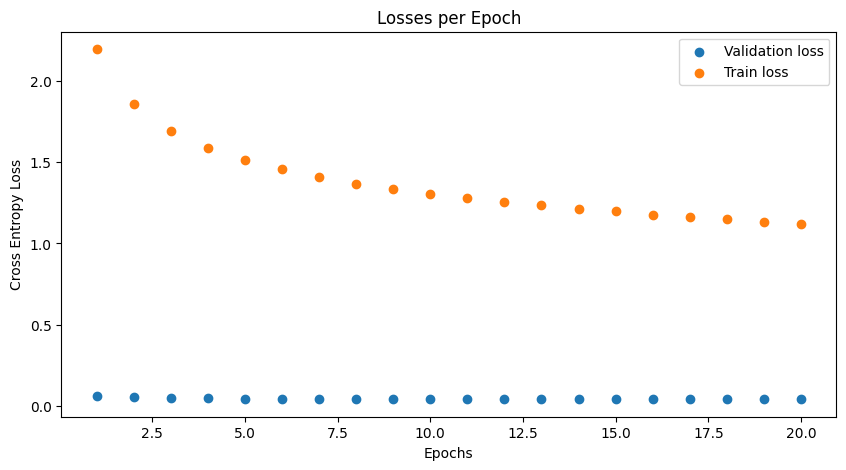

<Figure size 1400x800 with 0 Axes>

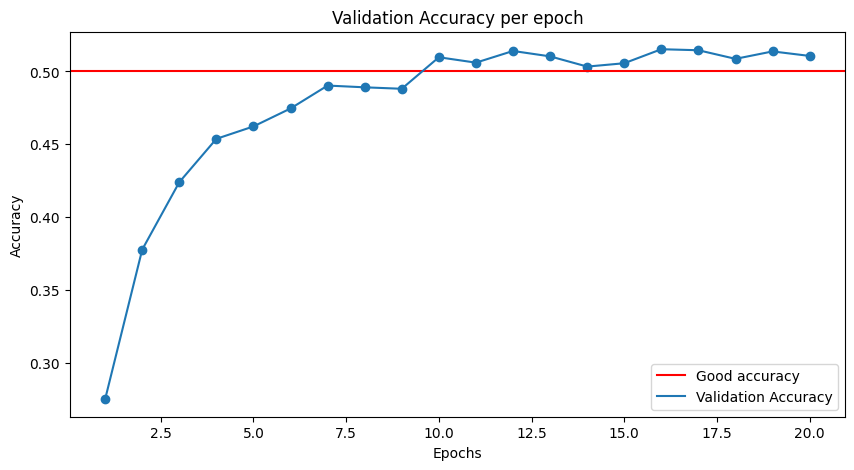

In [25]:
x_val = np.arange(1, epochs+1)
train_loss_hist_epochs = [np.mean(dict_log["train_loss_hist"][i*len(train_loader):(i+1)*len(train_loader)]) for i in range(epochs)]

loss_plot('Losses per Epoch')
plt.scatter(x_val, dict_log["val_loss_hist"], label='Validation loss')
plt.scatter(x_val, train_loss_hist_epochs, label='Train loss')
plt.legend()
plt.savefig('Losses1.png')
plt.show()

plt.figure(figsize=(14,8))
acc_plot('Validation Accuracy per epoch')
plt.scatter(x_val, dict_log["val_acc_hist"])
plt.plot(x_val, dict_log["val_acc_hist"], label='Validation Accuracy')
plt.legend()
plt.savefig('Accuracy1.png')
plt.show()

**Expected Output:** Your plots should look somewhat similar to this:

![Losses1.png](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a06_pytorch_mlp/images/Losses1.png)

![Accuracy1.png](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a06_pytorch_mlp/images/Accuracy1.png)

# 7. Hyperparameter tuning

Lastly, we want to squeeze some more performance out of our model by tuning its hyperparameters.

**Exercise:** Implement the function hparam_tuning below. It should:
- Take in lists of hyperparameters
- Test every possible combination of them.

The epochs, in_channels and num_classes are fixed. You can experiment with the parameters hidden sizes, learning rate, momentum and weight decay.

Save the dictionaries returned by the train function in the logs_out list. Don't forget to re-initialize your model before each run with new hyperparameters

In [30]:
from itertools import product
def hparam_tuning(epochs, in_channels, hidden_sizes, lrs, momentums, wds, num_classes=10):
    """
    params:
    epochs: int
    in_channels: int
    num_classes: int
    hidden_sizes: list of lists of ints
    lrs/momentums/wds: list of floats
    """
    logs_out = []
    ### START CODE HERE ### (approx. 7 lines)
    for ls, m, w in product(lrs, momentums, wds):
      model = MLP(in_channels, num_classes, hidden_sizes).to(device)
      dict_out = train(model, train_loader, val_loader, epochs, ls, m, w)

      logs_out.append(dict_out)


    ### END CODE HERE ###
    return logs_out

**Exercise:** Pick **at least 4 combinations of hyperparameters** and use them for a comparative series of training runs. Since you pass lists of hyperparameters, this means two of the lists need to be at least of length 2.

Epoch 1/5 done. Train loss: 1.800 val loss: 0.051 Val. Accuracy : 42.910%.
Epoch 2/5 done. Train loss: 1.570 val loss: 0.047 Val. Accuracy : 46.280%.
Epoch 3/5 done. Train loss: 1.481 val loss: 0.046 Val. Accuracy : 47.550%.
Epoch 4/5 done. Train loss: 1.427 val loss: 0.046 Val. Accuracy : 48.410%.
Epoch 5/5 done. Train loss: 1.389 val loss: 0.045 Val. Accuracy : 48.930%.
Epoch 1/5 done. Train loss: 1.763 val loss: 0.049 Val. Accuracy : 44.280%.
Epoch 2/5 done. Train loss: 1.553 val loss: 0.048 Val. Accuracy : 45.370%.
Epoch 3/5 done. Train loss: 1.472 val loss: 0.048 Val. Accuracy : 46.360%.
Epoch 4/5 done. Train loss: 1.419 val loss: 0.046 Val. Accuracy : 47.470%.
Epoch 5/5 done. Train loss: 1.381 val loss: 0.046 Val. Accuracy : 49.020%.
Epoch 1/5 done. Train loss: 2.210 val loss: 0.072 Val. Accuracy : 10.000%.
Epoch 2/5 done. Train loss: 2.309 val loss: 0.072 Val. Accuracy : 10.000%.
Epoch 3/5 done. Train loss: 2.310 val loss: 0.072 Val. Accuracy : 10.000%.
Epoch 4/5 done. Train los

<Figure size 1400x800 with 0 Axes>

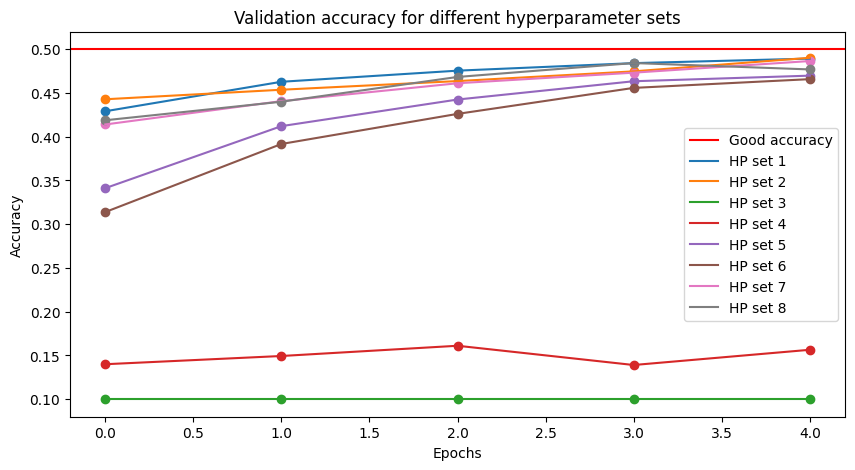

In [32]:
### START CODE HERE ### (approx. 4 lines)
epochs, in_channels= 5, 3*32*32
hidden_sizes=[64,32,16]
lrs = [1e-02, 1e-03]
momentums=[0.9,0.99]
wds = [1e-04, 1e-05]

### END CODE HERE ###

logs_out = hparam_tuning(epochs, in_channels, hidden_sizes, lrs, momentums, wds)

plt.figure(figsize=(14,8))
acc_plot("Validation accuracy for different hyperparameter sets")
for c, dict_out in enumerate(logs_out):
    x_val = list(range(len(dict_out["val_acc_hist"])))
    plt.scatter(x_val, dict_out["val_acc_hist"])
    plt.plot(x_val, dict_out["val_acc_hist"], label=f"HP set {c+1}")
plt.legend()
plt.show()

**Expected Output:** Your plots should look somewhat similar to this:

![Accuracy2.png](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a06_pytorch_mlp/images/Accuracy2.png)